# Imports

In [1]:
from Models import *
from src.digit_functions import loadTestDigits
from src.sudoku_functions import loadSudokus
from src.sudoku_solver_functions import *
from src.feature_functions import *

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2 as cv

In [2]:
pixelModel = torch.load("./models/pixel.pth")
sudokuDataset = loadSudokus("./data/sudokus")
print(f"(+) Sudoku dataset shape: ({sudokuDataset[0].shape}, {sudokuDataset[1].shape})")

(+) Reading data from .npy file...
(+) Sudoku loading finished
(+) Sudoku dataset shape: ((55,), (55, 9, 9))


Wrong Empty Cell Classification Extraction

In [3]:
sudokus = (sudokuDataset[0].copy(), sudokuDataset[1].copy())
models = [pixelModel]
featureFunctions = [pixelFeatureFunction]

zeroPredeterminationErrors = {
    'trueZero': [],
    'predZero': []
}

for data, label in zip(sudokus[0], sudokus[1]):

    img = data.copy()
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sudokuImageGrayScale, sudokuContours = detectSudokuInGrayScaleImage(imgGray)

    if sudokuImageGrayScale is None or sudokuContours is None: 
        continue

    cells = retrieveCellsFromSudokuImage(sudokuImageGrayScale)

    sudoku = classifyCells(cells, models, featureFunctions)

    for xIndex in range(0, 9):
        for yIndex in range(0, 9):
            _y = sudoku[xIndex, yIndex]
            y = label[xIndex, yIndex]

            if _y != y: 
                wouldHaveSolved = False
                if y == 0:
                    zeroPredeterminationErrors['trueZero'].append(cells[xIndex, yIndex])
                if _y == 0:
                    zeroPredeterminationErrors['predZero'].append(cells[xIndex, yIndex])

True Zeros

In [4]:
len(zeroPredeterminationErrors['trueZero'])

4

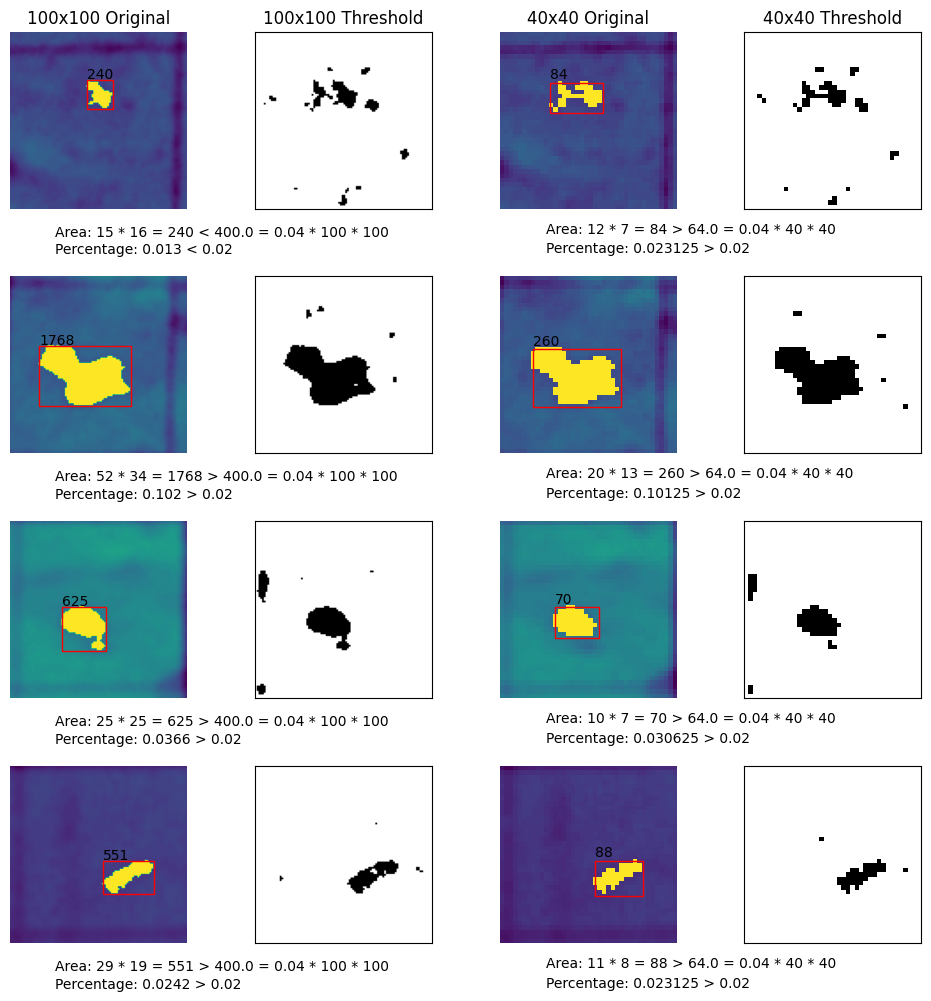

In [5]:
fig, axs = plt.subplots(len(zeroPredeterminationErrors['trueZero']), 4, figsize=(10, 10))
fig.tight_layout(pad=1.5)

axs[0][0].set_title("100x100 Original")
axs[0][1].set_title("100x100 Threshold")
axs[0][2].set_title("40x40 Original")
axs[0][3].set_title("40x40 Threshold")
for cell, axis in zip(zeroPredeterminationErrors['trueZero'], axs): 

    original = cell.copy()
    originalThresh = cv.threshold(original.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    originalThresh = clear_border(originalThresh)

    originalContours, _ = cv.findContours(originalThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    originalContour = None
    if len(originalContours) > 0:
        originalContour = max(originalContours, key=cv.contourArea)
        (h, w) = originalThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(originalContour)
        mask = np.zeros(originalThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [originalContour], -1, 255, cv.FILLED)

        (h, w) = originalThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

    axis[0].imshow(cv.drawContours(original.copy(), [originalContour], -1, (255, 0, 0), cv.FILLED) if originalContour is not None else original.copy())
    axis[0].axis('off')
    if originalContour is not None:
        axis[0].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[0].add_patch(rect)
        axis[0].text(25, 115, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[0].text(25, 125, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
    axis[1].imshow(255 - originalThresh, cmap="gray")
    axis[1].set_xticks([])
    axis[1].set_yticks([])

    resized = cv.resize(cell.copy(), (40, 40))
    resizedThresh = cv.threshold(resized.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    resizedThresh = clear_border(resizedThresh)

    resizedContours, _ = cv.findContours(resizedThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    resizedContour = None
    if len(resizedContours) > 0:
        resizedContour = max(resizedContours, key=cv.contourArea)
        (h, w) = resizedThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(resizedContour)
        mask = np.zeros(resizedThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [resizedContour], -1, 255, cv.FILLED)

        (h, w) = resizedThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

    axis[2].imshow(cv.drawContours(resized.copy(), [resizedContour], -1, (255, 0, 0), cv.FILLED) if resizedContour is not None else resized.copy())
    axis[2].axis('off')
    if resizedContour is not None:
        axis[2].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[2].add_patch(rect)
        axis[2].text(10, 45, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[2].text(10, 49.5, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
    axis[3].imshow(255 - resizedThresh, cmap="gray")
    axis[3].set_xticks([])
    axis[3].set_yticks([])

plt.savefig("./figures/trueZeroWrongClassification.png")

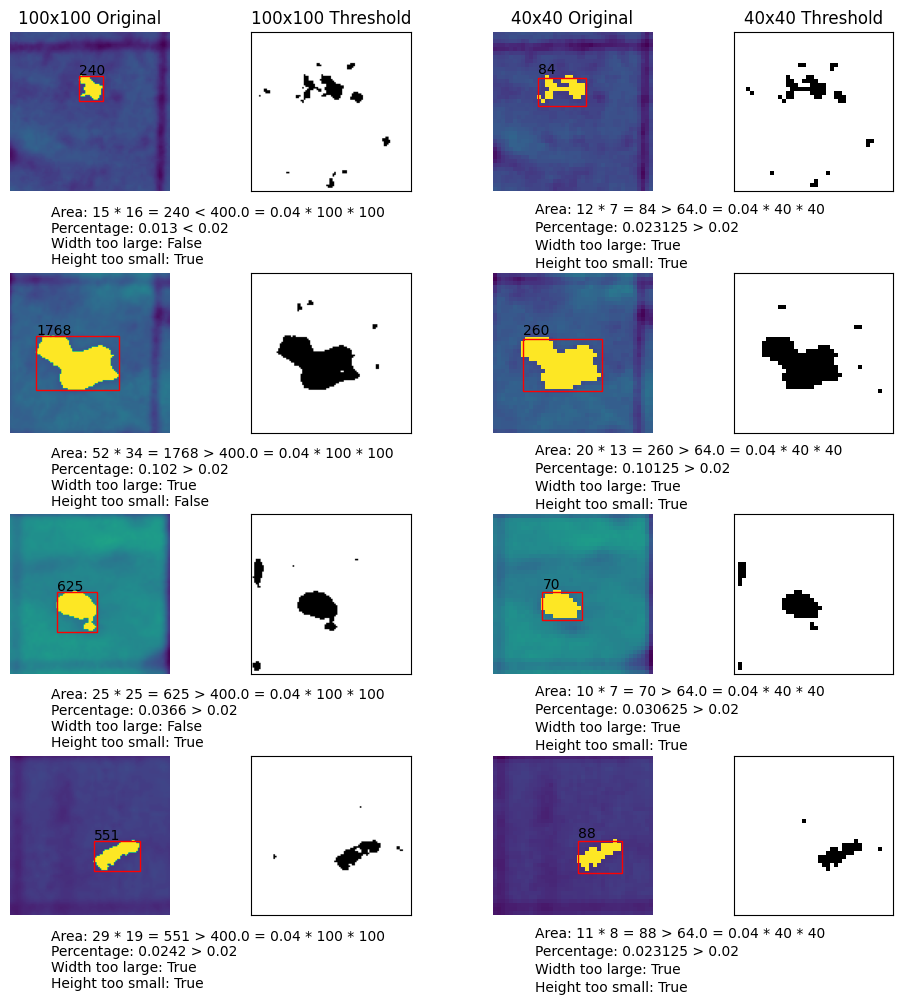

In [6]:
fig, axs = plt.subplots(len(zeroPredeterminationErrors['trueZero']), 4, figsize=(10, 10))
fig.tight_layout(pad=2.5)

axs[0][0].set_title("100x100 Original")
axs[0][1].set_title("100x100 Threshold")
axs[0][2].set_title("40x40 Original")
axs[0][3].set_title("40x40 Threshold")
for cell, axis in zip(zeroPredeterminationErrors['trueZero'], axs): 

    original = cell.copy()
    originalThresh = cv.threshold(original.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    originalThresh = clear_border(originalThresh)

    originalContours, _ = cv.findContours(originalThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    originalContour = None
    widthTooLarge = None
    heightTooSmall = None
    if len(originalContours) > 0:
        originalContour = max(originalContours, key=cv.contourArea)
        (h, w) = originalThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(originalContour)
        mask = np.zeros(originalThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [originalContour], -1, 255, cv.FILLED)

        (h, w) = originalThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

        widthTooLarge = w_contour > h_contour    
        heightTooSmall = h_contour < h * float(1.0/3.0) 

    axis[0].imshow(cv.drawContours(original.copy(), [originalContour], -1, (255, 0, 0), cv.FILLED) if originalContour is not None else original.copy())
    axis[0].axis('off')
    if originalContour is not None:
        axis[0].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[0].add_patch(rect)
        axis[0].text(25, 115, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[0].text(25, 125, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
        axis[0].text(25, 135, f"Width too large: {widthTooLarge}")
        axis[0].text(25, 145, f"Height too small: {heightTooSmall}")
    axis[1].imshow(255 - originalThresh, cmap="gray")
    axis[1].set_xticks([])
    axis[1].set_yticks([])

    resized = cv.resize(cell.copy(), (40, 40))
    resizedThresh = cv.threshold(resized.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    resizedThresh = clear_border(resizedThresh)

    resizedContours, _ = cv.findContours(resizedThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    resizedContour = None
    widthTooLarge = None
    heightTooSmall = None
    if len(resizedContours) > 0:
        resizedContour = max(resizedContours, key=cv.contourArea)
        (h, w) = resizedThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(resizedContour)
        mask = np.zeros(resizedThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [resizedContour], -1, 255, cv.FILLED)

        (h, w) = resizedThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

        widthTooLarge = w_contour > h_contour    
        heightTooSmall = h_contour < h * float(1.0/3.0) 

    axis[2].imshow(cv.drawContours(resized.copy(), [resizedContour], -1, (255, 0, 0), cv.FILLED) if resizedContour is not None else resized.copy())
    axis[2].axis('off')
    if resizedContour is not None:
        axis[2].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[2].add_patch(rect)
        axis[2].text(10, 45, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[2].text(10, 49.5, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
        axis[2].text(10, 54, f"Width too large: {widthTooLarge}")
        axis[2].text(10, 58.5, f"Height too small: {heightTooSmall}")
    axis[3].imshow(255 - resizedThresh, cmap="gray")
    axis[3].set_xticks([])
    axis[3].set_yticks([])

plt.savefig("./figures/trueZeroWrongClassificationSolved.png")

Predicted Zeros

In [7]:
len(zeroPredeterminationErrors['predZero'])

3

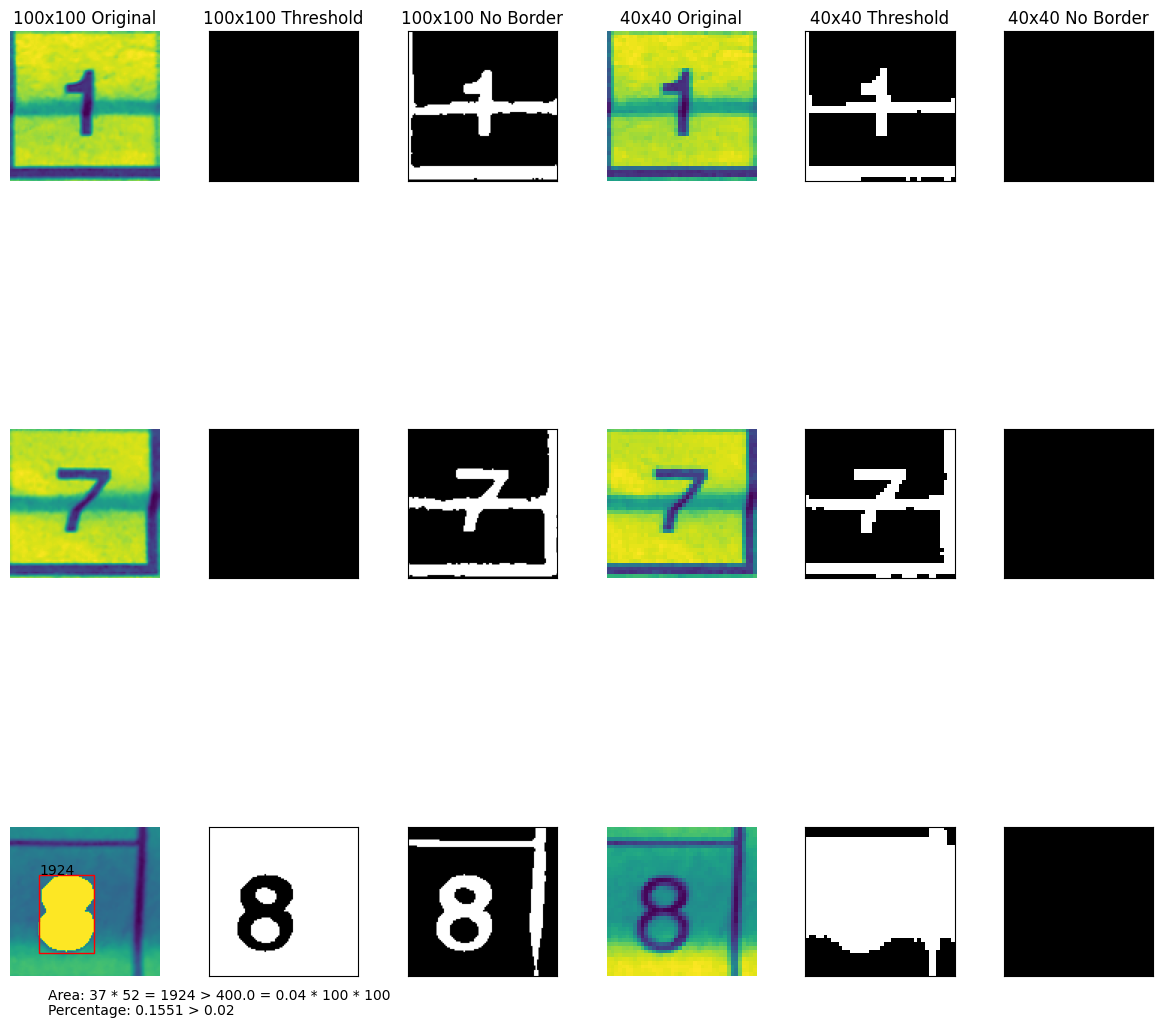

In [8]:
fig, axs = plt.subplots(len(zeroPredeterminationErrors['predZero']), 6, figsize=(12, 12))
fig.tight_layout(pad=0.5)

axs[0][0].set_title("100x100 Original")
axs[0][1].set_title("100x100 Threshold")
axs[0][2].set_title("100x100 No Border")
axs[0][3].set_title("40x40 Original")
axs[0][4].set_title("40x40 Threshold")
axs[0][5].set_title("40x40 No Border")
for cell, axis in zip(zeroPredeterminationErrors['predZero'], axs): 

    original = cell.copy()
    originalThresh = cv.threshold(original.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    axis[2].imshow(originalThresh, cmap="gray")
    axis[2].set_xticks([])
    axis[2].set_yticks([])
    originalThresh = clear_border(originalThresh)

    originalContours, _ = cv.findContours(originalThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    originalContour = None
    if len(originalContours) > 0:
        originalContour = max(originalContours, key=cv.contourArea)
        (h, w) = originalThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(originalContour)
        mask = np.zeros(originalThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [originalContour], -1, 255, cv.FILLED)

        (h, w) = originalThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

    axis[0].imshow(cv.drawContours(original.copy(), [originalContour], -1, (255, 0, 0), cv.FILLED) if originalContour is not None else original.copy())
    axis[0].axis('off')
    if originalContour is not None:
        axis[0].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[0].add_patch(rect)
        axis[0].text(25, 115, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[0].text(25, 125, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
    axis[1].imshow(255 - originalThresh, cmap="gray")
    axis[1].set_xticks([])
    axis[1].set_yticks([])

    resized = cv.resize(cell.copy(), (40, 40))
    resizedThresh = cv.threshold(resized.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    axis[4].imshow(resizedThresh.copy(), cmap="gray")
    axis[4].set_xticks([])
    axis[4].set_yticks([])
    resizedThresh = clear_border(resizedThresh)

    resizedContours, _ = cv.findContours(resizedThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    resizedContour = None
    if len(resizedContours) > 0:
        resizedContour = max(resizedContours, key=cv.contourArea)
        (h, w) = resizedThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(resizedContour)
        mask = np.zeros(resizedThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [resizedContour], -1, 255, cv.FILLED)

        (h, w) = resizedThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

    axis[3].imshow(cv.drawContours(resized.copy(), [resizedContour], -1, (255, 0, 0), cv.FILLED) if resizedContour is not None else resized.copy())
    axis[3].axis('off')
    if resizedContour is not None:
        axis[3].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[3].add_patch(rect)
        axis[3].text(10, 45, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[3].text(10, 49.5, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
    axis[5].imshow(255 - resizedThresh, cmap="gray")
    axis[5].set_xticks([])
    axis[5].set_yticks([])

plt.savefig("./figures/predZeroWrongClassification.png")

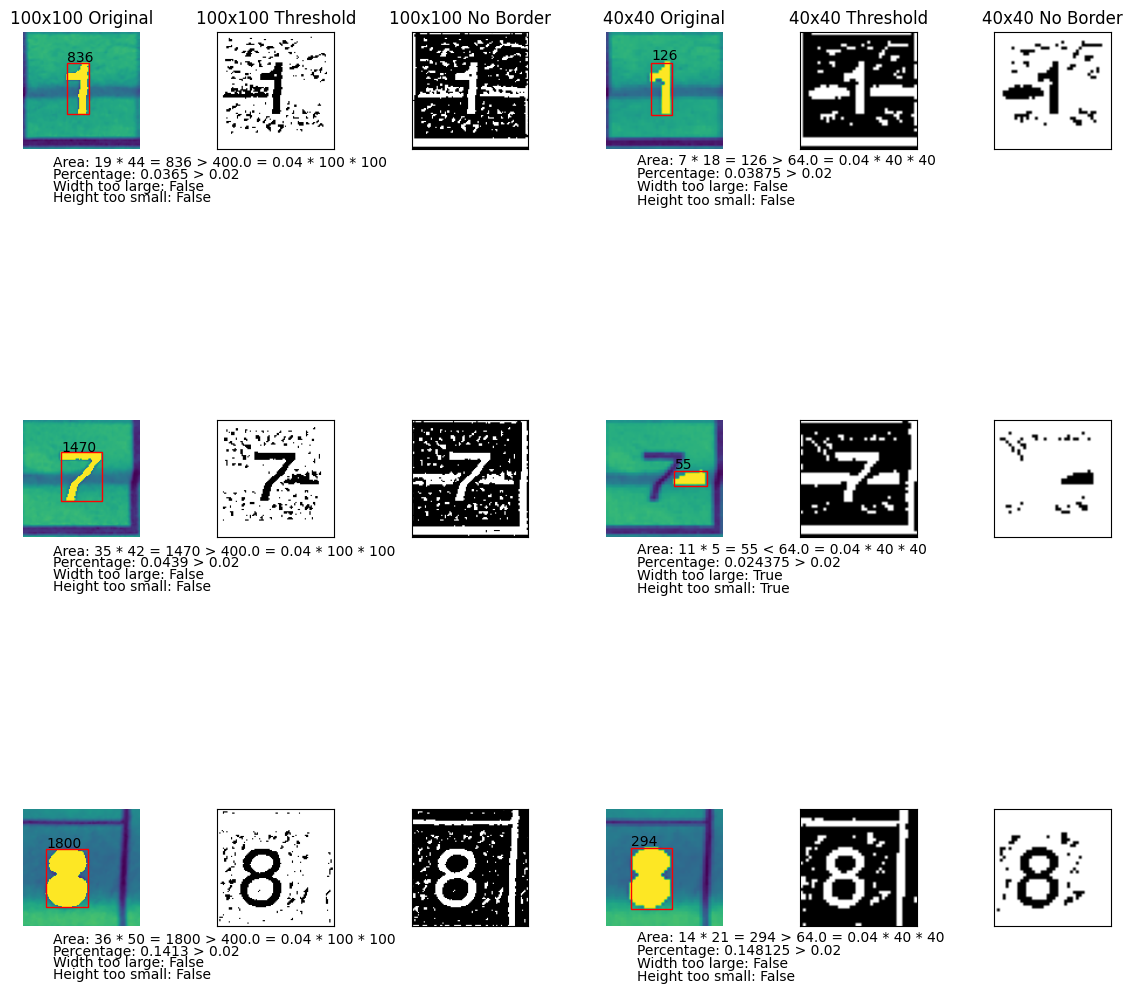

In [9]:
fig, axs = plt.subplots(len(zeroPredeterminationErrors['predZero']), 6, figsize=(12, 12))
fig.tight_layout(pad=2.5)

axs[0][0].set_title("100x100 Original")
axs[0][1].set_title("100x100 Threshold")
axs[0][2].set_title("100x100 No Border")
axs[0][3].set_title("40x40 Original")
axs[0][4].set_title("40x40 Threshold")
axs[0][5].set_title("40x40 No Border")
for cell, axis in zip(zeroPredeterminationErrors['predZero'], axs): 

    original = cell.copy()
    originalAdaptiveThresh = cv.adaptiveThreshold(original.copy(), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    originalThresh = cv.threshold(originalAdaptiveThresh.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    axis[2].imshow(originalThresh, cmap="gray")
    axis[2].set_xticks([])
    axis[2].set_yticks([])
    originalThresh = clear_border(originalThresh)

    originalContours, _ = cv.findContours(originalThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    originalContour = None
    if len(originalContours) > 0:
        originalContour = max(originalContours, key=cv.contourArea)
        (h, w) = originalThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(originalContour)
        mask = np.zeros(originalThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [originalContour], -1, 255, cv.FILLED)

        (h, w) = originalThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

        widthTooLarge = w_contour > h_contour    
        heightTooSmall = h_contour < h * float(1.0/3.0) 

    axis[0].imshow(cv.drawContours(original.copy(), [originalContour], -1, (255, 0, 0), cv.FILLED) if originalContour is not None else original.copy())
    axis[0].axis('off')
    if originalContour is not None:
        axis[0].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[0].add_patch(rect)
        axis[0].text(25, 115, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[0].text(25, 125, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
        axis[0].text(25, 135, f"Width too large: {widthTooLarge}")
        axis[0].text(25, 145, f"Height too small: {heightTooSmall}")
    axis[1].imshow(255 - originalThresh, cmap="gray")
    axis[1].set_xticks([])
    axis[1].set_yticks([])

    resized = cv.resize(cell.copy(), (40, 40))
    resizedAdaptiveThresh = cv.adaptiveThreshold(resized.copy(), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    resizedThresh = cv.threshold(resizedAdaptiveThresh.copy(), 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    axis[4].imshow(resizedThresh, cmap="gray")
    axis[4].set_xticks([])
    axis[4].set_yticks([])
    resizedThresh = clear_border(resizedThresh)

    resizedContours, _ = cv.findContours(resizedThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    resizedContour = None
    if len(resizedContours) > 0:
        resizedContour = max(resizedContours, key=cv.contourArea)
        (h, w) = resizedThresh.shape
        x_contour, y_contour, w_contour, h_contour = cv.boundingRect(resizedContour)
        mask = np.zeros(resizedThresh.shape, dtype=np.uint8)
        cv.drawContours(mask, [resizedContour], -1, 255, cv.FILLED)

        (h, w) = resizedThresh.shape
        percentageFilled = cv.countNonZero(mask) / float(w *h)

        widthTooLarge = w_contour > h_contour    
        heightTooSmall = h_contour < h * float(1.0/3.0) 

    axis[3].imshow(cv.drawContours(resized.copy(), [resizedContour], -1, (255, 0, 0), cv.FILLED) if resizedContour is not None else resized.copy())
    axis[3].axis('off')
    if resizedContour is not None:
        axis[3].text(x_contour, y_contour - 1, f"{w_contour * h_contour}")
        rect = patches.Rectangle((x_contour, y_contour), w_contour, h_contour, linewidth=1, edgecolor='r', facecolor='none')
        axis[3].add_patch(rect)
        axis[3].text(10, 45, f"Area: {w_contour} * {h_contour} = {w_contour * h_contour} {'<' if w_contour * h_contour < 0.04*h*w else '>'} {0.04*h*w} = 0.04 * {h} * {w}")
        axis[3].text(10, 49.5, f"Percentage: {percentageFilled} {'<' if percentageFilled < 0.02 else '>'} 0.02")
        axis[3].text(10, 54, f"Width too large: {widthTooLarge}")
        axis[3].text(10, 58.5, f"Height too small: {heightTooSmall}")
    axis[5].imshow(255 - resizedThresh, cmap="gray")
    axis[5].set_xticks([])
    axis[5].set_yticks([])

plt.savefig("./figures/predZeroWrongClassificationSolved.png")